##  Import library

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


## 1.Load Data

In [24]:
# Load data
df = pd.read_csv("data/Walmart.csv")
print(df.shape)
df.head()

(6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## 2. Data Understanding

In [25]:
# Konversi kolom Date ke format datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
print("\nInfo dataset:")
df.info()


Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [26]:
# Pemeriksaan missing values
print("\nMissing values per kolom:")
print(df.isnull().sum())


Missing values per kolom:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [27]:
# Analisis statistik deskriptif
print("\nStatistik deskriptif:")
df.describe()


Statistik deskriptif:


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


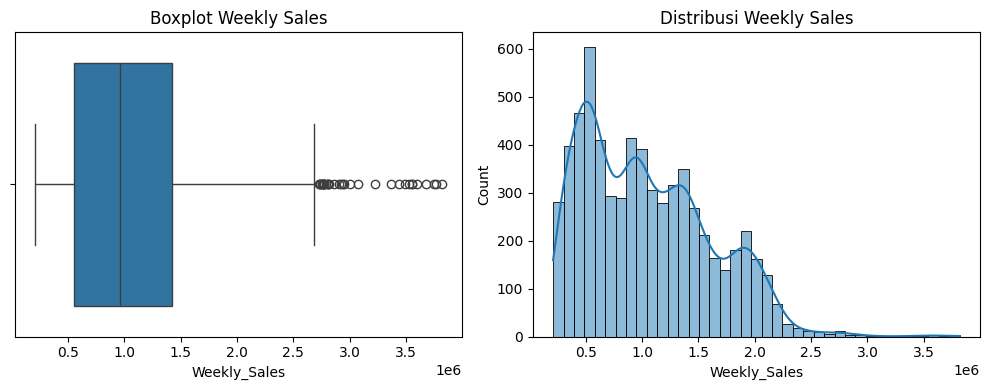

In [28]:
# Visualisasi distribusi penjualan dan outlier
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Weekly_Sales'])
plt.title("Boxplot Weekly Sales")

plt.subplot(1, 2, 2)
sns.histplot(df['Weekly_Sales'], kde=True)
plt.title("Distribusi Weekly Sales")
plt.tight_layout()
plt.show()


## 3. Data Preparation

In [29]:
# Penanganan outlier dengan IQR
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

In [30]:
print(f"\nBatas atas outlier: {upper_bound:.2f}")
print(f"Jumlah data sebelum pembersihan: {len(df)}")
df = df[df['Weekly_Sales'] <= upper_bound]
print(f"Jumlah data setelah pembersihan: {len(df)}")
print(f"Outlier yang dihapus: {6435-6361} ({((6435-6361)/6435)*100:.2f}%)")


Batas atas outlier: 2720371.49
Jumlah data sebelum pembersihan: 6435
Jumlah data setelah pembersihan: 6401
Outlier yang dihapus: 74 (1.15%)


In [31]:
# Persiapan data untuk modeling
sales_df = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
sales_df.columns = ['ds', 'y']  # Format khusus Prophet
sales_df = sales_df.sort_values('ds')

In [32]:
print("\nContoh data yang sudah diproses:")
sales_df.head()


Contoh data yang sudah diproses:


,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


## 4. Exploratory Data Analysis

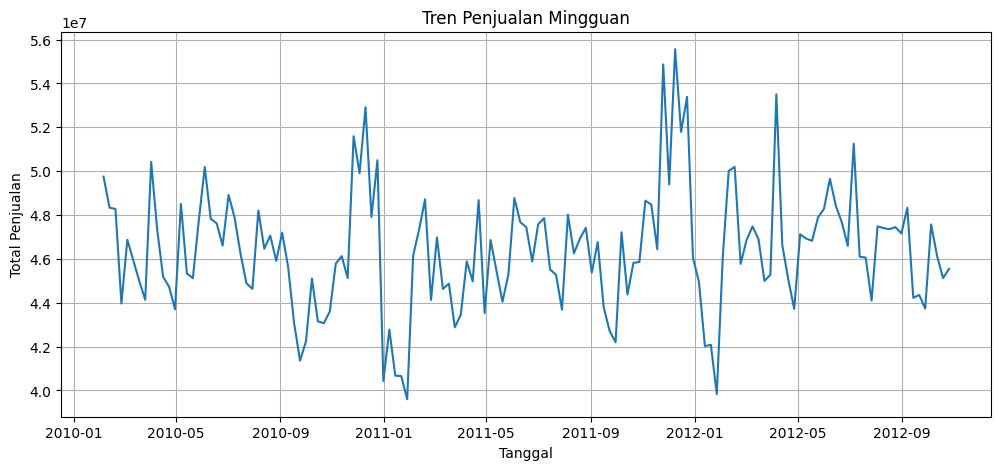

In [33]:
# Analisis tren temporal
plt.figure(figsize=(12, 5))
plt.plot(sales_df['ds'], sales_df['y'])
plt.title("Tren Penjualan Mingguan")
plt.xlabel("Tanggal")
plt.ylabel("Total Penjualan")
plt.grid(True)
plt.show()

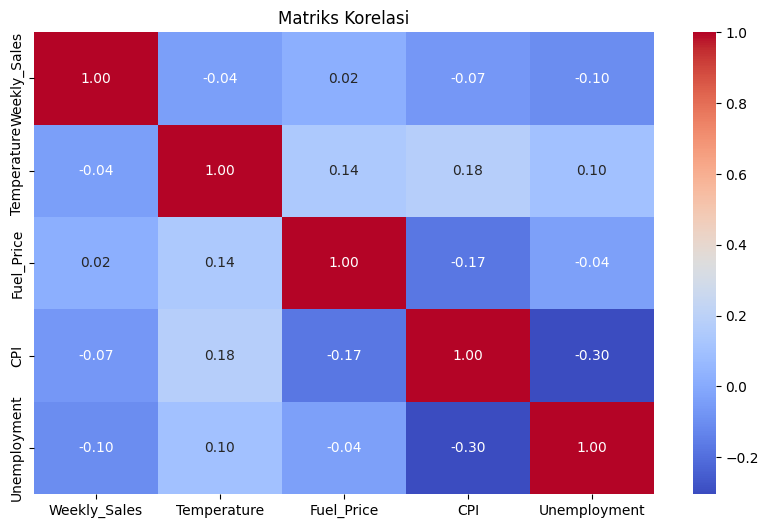

In [34]:
# Analisis korelasi
numerics = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerics].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

## 5. Modeling

### 5.1 Prophet Model

In [35]:
# Inisialisasi dan training model Prophet
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

prophet_model.fit(sales_df)

09:56:46 - cmdstanpy - INFO - Chain [1] start processing
09:56:46 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# Membuat prediksi
future = prophet_model.make_future_dataframe(periods=12, freq='W')
forecast = prophet_model.predict(future)

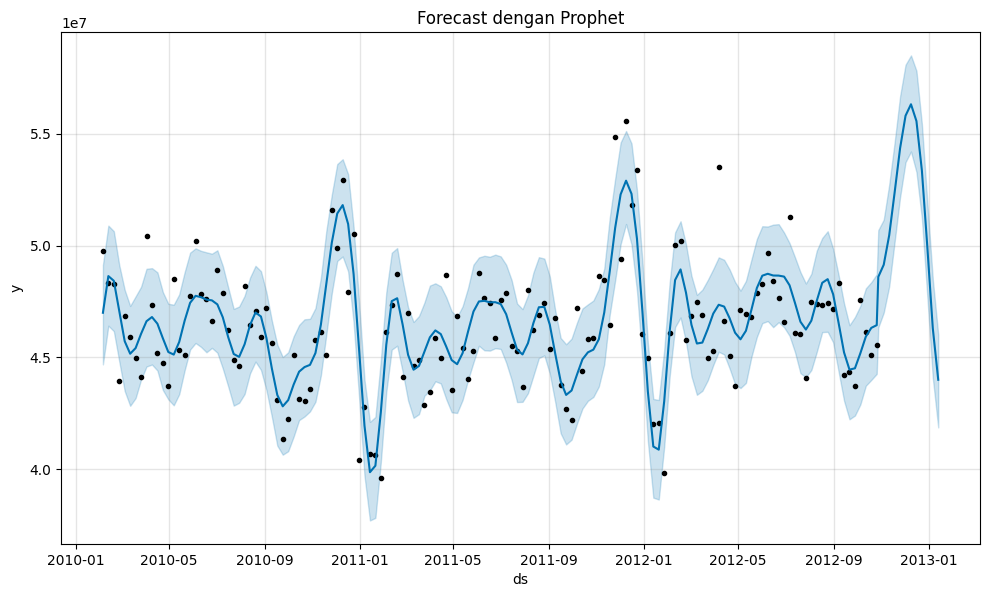

In [37]:
# Visualisasi hasil
fig1 = prophet_model.plot(forecast)
plt.title("Forecast dengan Prophet")
plt.show()

### 5.2 SARIMAX Model

In [38]:
# Persiapan data untuk SARIMAX
sarima_df = sales_df.set_index('ds')
train = sarima_df.iloc[:-12]
test = sarima_df.iloc[-12:]

In [39]:
# Training model SARIMAX
sarima_model = SARIMAX(
    train['y'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)

c:\Users\ghani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\ghani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\ghani\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


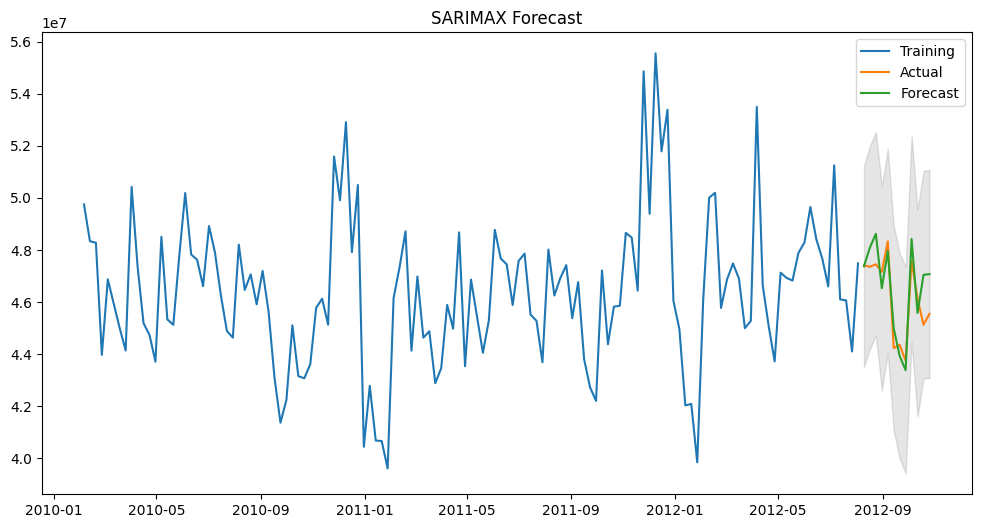

In [40]:
# Membuat prediksi dan visualisasi
sarima_forecast = sarima_result.get_forecast(steps=12)
pred_ci = sarima_forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['y'], label='Training')
plt.plot(test.index, test['y'], label='Actual')
plt.plot(test.index, sarima_forecast.predicted_mean, label='Forecast')
plt.fill_between(test.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title("SARIMAX Forecast")
plt.legend()
plt.show()

## 6. Evaluation

In [41]:
# Evaluasi Prophet
prophet_forecast = forecast.set_index('ds').loc[test.index]['yhat']
mae_prophet = mean_absolute_error(test['y'], prophet_forecast)
rmse_prophet = sqrt(mean_squared_error(test['y'], prophet_forecast))

In [42]:
# Evaluasi SARIMAX
sarima_pred = sarima_forecast.predicted_mean
mae_sarima = mean_absolute_error(test['y'], sarima_pred)
rmse_sarima = sqrt(mean_squared_error(test['y'], sarima_pred))

In [43]:
# Tampilkan hasil evaluasi
print("=== Hasil Evaluasi ===")
print(f"{'Model':<10} | {'MAE':>12} | {'RMSE':>12}")
print("-"*40)
print(f"{'Prophet':<10} | {mae_prophet:12.2f} | {rmse_prophet:12.2f}")
print(f"{'SARIMAX':<10} | {mae_sarima:12.2f} | {rmse_sarima:12.2f}")

=== Hasil Evaluasi ===
Model      |          MAE |         RMSE
----------------------------------------
Prophet    |    930731.93 |   1127577.48
SARIMAX    |    779985.66 |    932019.49
